# Birmingham Purchase Cards Transactions <a class='tocSkip'>
-----
## Ana Isabel Rúa G.
## Msc.(c)Technology Information - Emphasis on Data Science <a class='tocSkip'>
#### https://github.com/anarua1203 

**Description:** With about 14  explanatory variables that describe (almost) all aspects of the corporate  purchase card transactions behavior for the Birmingham City Council, the idea for this paper is to use machine learning to explore and gain deeper knowledge from this data set.

** Where does this data comes from?:** Under the Code of Recommended Practice for Local Authorities on Data Transparency, councils are encouraged to publish all corporate purchase card transactions. 

Birmingham City Council has already publish details of all their relevant expenditure of more than £500 within Payments to Suppliers page, and will continue to do so. However, in the spirit of the Code, the Council started publishing all purchase card transactions, regardless of value, from the April 2014 card statement. 

Data: https://data.birmingham.gov.uk/dataset/purchase-card-transactions


**Problem tasks:** 
* (Clustering) Discovering profiles (whether the case) or unusual transactions (anomalies detection)
* (Forecasting) Try to guess future transactional behaviors. 

# Import Libraries

In [105]:
#  Basic Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Data preprocessing
from sklearn import preprocessing

warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
# Change pandas viewing options
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)
#pd.set_option('display.width', 1000)

For this part of the project I'll import data preprocessed in *1.Birmingham_preprocess.ipynb* and from there, we will continue our *EDA* and data cleaning.


In [76]:
df = pd.read_csv('../data/interim/purchase_card_trans_clean.csv', sep='|')
print(f'The Dataframe have {df.shape[0]} rows and {df.shape[1]} columns')
print('-----------------------------------------')
df.head()

Data frame has 161962 rows and 11 columns
-----------------------------------------


trans_date trans_vat_desc  original_gross_amt      merchant_name  \
0  2015-05-06             VR               38.28  shell corrida 108   
1  2015-05-14             VR               34.23      tex city sstn   
2  2015-05-21             VR               42.61      tex city sstn   
3  2015-05-29             VR               43.57      tex city sstn   
4  2015-05-07             VR               54.17    shell kings 587   

        card_number trans_cac_code_1 trans_cac_desc_1 trans_cac_code_2  \
0  ************0541             K020     Vehicle Fuel            RV12T   
1  ************0541             K020     Vehicle Fuel            RV12T   
2  ************0541             K020     Vehicle Fuel            RV12T   
3  ************0541             K020     Vehicle Fuel            RV12T   
4  ************5770             K020     Vehicle Fuel            RV12N   

                         trans_cac_desc_2 trans_cac_code_3  \
0  Shakti Elders Dce, 73 Conybere St, B12              A00   
1  Shakti Elders Dce, 73 Conybere St, B12              A00   
2  Shakti Elders Dce, 73 Conybere St, B12              A00   
3  Shakti Elders Dce, 73 Conybere St, B12              A00   
4                    African-Caribbean DC              A00   

           directorate  
0  Adult & Communities  
1  Adult & Communities  
2  Adult & Communities  
3  Adult & Communities  
4  Adult & Communities

In [15]:
# Funcion para calcular el % de datos faltantes para cada columnas 
def missing_values_table(df_adf_append):
    # Total valores faltantes
    mis_val = df_adf_append.isnull().sum()
    
    # % valores faltantes 
    mis_val_percent = 100 * df_adf_append.isnull().sum() / len(df_adf_append)
    
    # Tabla para presentar datos
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    
    # Renombrar columnas
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing ', 1 : '% of Total Values'})
    
    # Ordena la tabla de mayor faltantes a menor
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    
    # Print resumen
    print ("Dataframe has " + str(df_adf_append.shape[1]) + " columnas.\n"      
        "of which " + str(mis_val_table_ren_columns.shape[0]) +
            " have missing values.")
    
    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [16]:
missing_values_table(df)

Dataframe has 11 columnas.
of which 0 have missing values.


Empty DataFrame
Columns: [Missing , % of Total Values]
Index: []

For our starting point we have a dataset without missing values

 I created a file named *ColumnsDescription.csv* manually, checking each feature to determine if a columns was numeric, categorical , or datetime. I added a column to express if the categorical feature can be represented in an ordinal way or needs to be represented in one hot encoding. Aditionaly I created an Anotations column where I wrote some notes regarding to the preprocess. Maybe this can be encode by python Rules but, since there where few columns, I decided to do this manually.

In [77]:
df_types = pd.read_csv('../data/interim/ColumnDescription.csv',sep=';')
df_types

Column Feature_Type   Type       Anotation  \
0           TRANS DATE     Datetime      -               -   
1       TRANS VAT DESC     Category    OHE       Re Encode   
2   ORIGINAL GROSS AMT      Numeric  float               -   
3        MERCHANT NAME       Object      -               -   
4          CARD NUMBER       Object      -               -   
5     TRANS CAC CODE 1     Category    OHE        High cor   
6     TRANS CAC DESC 1     Category    OHE       Re Encode   
7     TRANS CAC CODE 2     Category    OHE        High cor   
8     TRANS CAC DESC 2     Category    OHE       Re Encode   
9     TRANS CAC CODE 3     Category    OHE  Check Variance   
10         Directorate     Category    OHE       Re Encode   

                                          Description  
0                                    Transaction date  
1   Value Added Tax Description: VR: Standard rate...  
2                               Original Gross Amount  
3                                      Merchant Name   
4                                          Identifier  
5                            Transaction concept code  
6                     Transaction Concept Description  
7   Code for Institution/program of the mayor's of...  
8   Institution/program of the mayor's office supp...  
9             Transaction Company Authentication Code  
10                Department who made the transaction

# Columns Behavior

Let's take a look at each categorical feature in the dataframe and analize whether we can re-encode values before making OHE process.

In [30]:
df.columns

Index(['trans_date', 'trans_vat_desc', 'original_gross_amt', 'merchant_name',
       'card_number', 'trans_cac_code_1', 'trans_cac_desc_1',
       'trans_cac_code_2', 'trans_cac_desc_2', 'trans_cac_code_3',
       'directorate'],
      dtype='object')

In [78]:
## Take categorical atributes prones to OHE
df_types['Column']= df_types['Column'].str.replace(' ', '_').str.lower()
columns_OHE=df_types[df_types.Type=='OHE']['Column'].tolist()
columns_OHE                               

['trans_vat_desc',
 'trans_cac_code_1',
 'trans_cac_desc_1',
 'trans_cac_code_2',
 'trans_cac_desc_2',
 'trans_cac_code_3',
 'directorate']

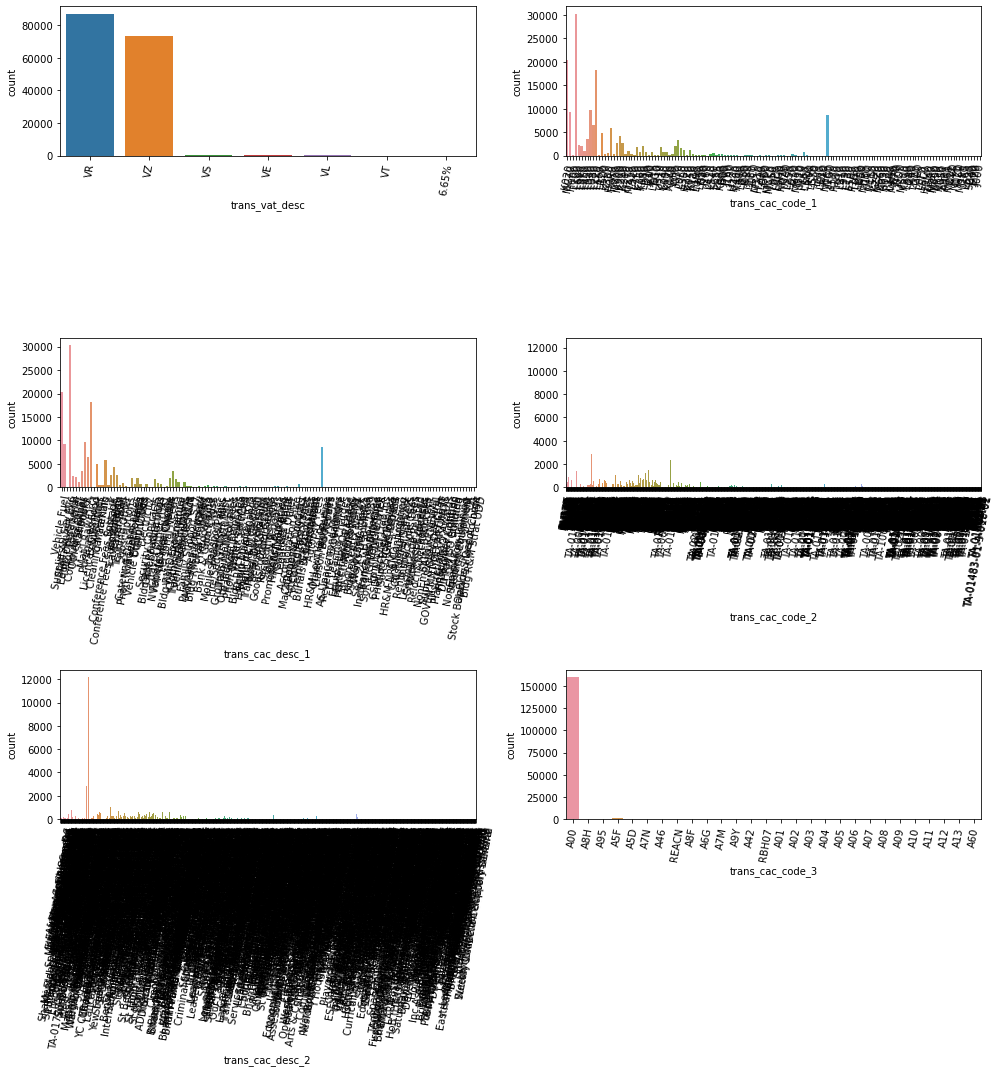

In [46]:
# Visualize features values distribution
categories = list(filter(lambda x:x in df.columns.tolist(),columns_OHE))
nr_cols = 2
nr_rows = len(categories)//nr_cols
li_cat_feats = categories
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*7,nr_rows*5))
for r in range(0,nr_rows):
    for c in range(0,nr_cols):
        i = r*nr_cols+c
        if i < len(li_cat_feats):
            sns.countplot(x=li_cat_feats[i], data=df, ax = axs[r][c])
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=80)
plt.tight_layout()
plt.show()

In [47]:
## Another way to see how each value is ditributed
for col in columns_OHE:
    if col in df.columns:
        print(col,'-------------',df[col].nunique())
        print(df[col].value_counts(normalize=True))
        print('-------------')

trans_vat_desc ------------- 7
VR       0.538200
VZ       0.452711
VL       0.004464
VE       0.003062
VS       0.001371
VT       0.000179
6.65%    0.000012
Name: trans_vat_desc, dtype: float64
-------------
trans_cac_code_1 ------------- 142
L100    0.187013
K020    0.125968
L220    0.112600
L030    0.059693
MC70    0.057304
          ...   
L690    0.000006
M600    0.000006
M660    0.000006
J1K5    0.000006
5C40    0.000006
Name: trans_cac_code_1, Length: 142, dtype: float64
-------------
trans_cac_desc_1 ------------- 142
Equip Operational       0.187013
Vehicle Fuel            0.125968
Purchases Food          0.112600
Books                   0.059693
Supplies & Sev Mic      0.057304
                          ...   
Planned Mtce Contrac    0.000006
Oil                     0.000006
NonEmpAllow-Training    0.000006
Leasing Prop Related    0.000006
Audit Fees              0.000006
Name: trans_cac_desc_1, Length: 142, dtype: float64
-------------
trans_cac_code_2 ------------- 1380
RUF0

From this point some important decisions have to be taken.

*    *trans_cac_code_3* has a low variance. 99% of the data corresponds to class A00, hence it is not meaningfull for further analysis and it will be removed from the data set.
*   For *trans_vat_desc* I'll impute VL,VE,VS,VT and 6.65% values and fill them with the mode, since it only represents 1% of the data.
*   *trans_cac_code_1* and *trans_cac_desc_1* are in essence the same data. So in order to gain interpretabilily I'll keep *trans_cac_desc_1* and remove *trans_cac_desc_1* from the data set.
*   Same process will be followed for *trans_cac_code_2* and *trans_cac_desc_2*.
*   In order to avoid high cardinality as much as possible once OHE process its been made, I will re-categorize the values that represent less than 1% of the data and create the *other* variable to host them.
*   For *directorate* feature, I can see it has some spelling mistakes so I'll perform a text cleanup

# Data Cleaning

In [79]:
## Removing columns from the dataframe.

columns_to_remove = ['trans_cac_code_1','trans_cac_code_2','trans_cac_code_3']
df.drop(columns_to_remove,axis=1,inplace=True)

print(f'The dataframe have {df.shape[0]} rows and {df.shape[1]} columns')
print('-----------------------------------------')

The dataframe have 161962 rows and 8 columns
-----------------------------------------


In [80]:
# Cleaning Directorate
print('Before text cleaning')
print('')
print(df.directorate.value_counts())
print('')
print('-----------------------------------------')
# I will impute the values of the column dictorate to deal with data governance problems
df['directorate'] = df['directorate'].str.lower().str.strip().str.replace('adults & comms','adults & communities').replace('adult & communities','adults & communities').replace('cyo&f','cyp&f schools').replace('cyp&f','cyp&f schools').replace('adults','adults & communities').replace('adult social care and health','adults & communities').replace(' ','_')
print('')
print('After text cleaning')
df['directorate'].value_counts()

Before text cleaning
CYP&F SCHOOLS                   84597
Local Services                  33831
CYP&F                           19409
Adult & Communities              9980
Corporate Resources              9679
DEVELOPMENT                      3036
CYP&F                             408
CYP&F Schools                     358
Adult Social Care and Health      346
CYP&F                             100
CYO&F                              74
Adults & Comms                     38
Development                        37
Local services                     35
Adults                             21
Adults & Communities               13
Name: directorate, dtype: int64

-----------------------------------------

After text cleaning


cyp&f schools           104946
local services           33866
adults & communities     10398
corporate resources       9679
development               3073
Name: directorate, dtype: int64

In Directorate column, we went from 16 categories to 5

In [87]:
## Re-encoding categories from trans_vat_desc.
df_filter = df["trans_vat_desc"].value_counts()
top = df_filter[df_filter>800]
print(f'Number of top categories = {len(top)}')

# Change categorie and fill it with mode value from that column
df.loc[~df['trans_vat_desc'].isin(list(top.index)),'trans_vat_desc']=df.trans_vat_desc.mode()
print(f'Now we go from having 7 values for trans_vat_desc feature to {df.trans_vat_desc.nunique()}')

Number of top categories = 2
Now we go from having 7 values for trans_vat_desc feature to 2


In [85]:
## Re-encoding categories from trans_cac_desc_1 feature with less than 200 records to Other
df_filter = df["trans_cac_desc_1"].value_counts()
top = df_filter[df_filter>200]
print(f'Number of top categories = {len(top)}')

# Change categorie and fill it with category Other
df.loc[~df['trans_cac_desc_1'].isin(list(top.index)),'trans_cac_desc_1']='Other'
print(f'Now we go from having 142 values for trans_cac_desc_1 feature to {df.trans_cac_desc_1.nunique()}')
df.trans_cac_desc_1.value_counts(normalize=True)

Number of top categories = 47
Now we go from having 142 values for trans_cac_desc_1 feature to 48


Equip Operational               0.187013
Vehicle Fuel                    0.125968
Purchases Food                  0.112600
Books                           0.059693
Supplies & Sev Mic              0.057304
Other Third Parties             0.053766
Mat'l Raw/Drct                  0.040133
Conference Fees Subs UK         0.035947
Equip Other                     0.030112
Hospitality                     0.026265
Stationery                      0.021894
Bldg RM Departmental            0.021073
Other                           0.020425
Postage                         0.016664
Travel Bus/Rail                 0.016547
Prof Fees other                 0.014534
Computing Other                 0.013182
Vehicle OthrunCosts             0.012633
Personal Needs                  0.012515
Phon NonCentrx Lines            0.011855
Other Fix&Fittings              0.010848
Visits Expenditure              0.010626
Vehicle Excise Lics             0.007502
Clothing&Uniforms               0.006909
Other Services  

In [86]:
## Re-encoding categories from trans_cac_desc_1 feature with less than 200 records to Other
df_filter = df["trans_cac_desc_2"].value_counts()
top = df_filter[df_filter>200]
print(f'Number of top categories = {len(top)}')

# Change categorie and fill it with category Other
df.loc[~df['trans_cac_desc_2'].isin(list(top.index)),'trans_cac_desc_2']='Other'
print(f'Now we go from having 1380 values for trans_cac_desc_2 feature to {df.trans_cac_desc_2.nunique()}')
df.trans_cac_desc_2.value_counts(normalize=True)

Number of top categories = 223
Now we go from having 1380 values for trans_cac_desc_2 feature to 224


Other                                     0.187149
Illegal Money Lending T Stds Comm Inv.    0.075357
Homeless Private Sector Accom             0.049913
The City of Birmingham School             0.027426
Camborne House HLDC                       0.017461
                                            ...   
Yenton JI                                 0.001278
TS-Fair Trading                           0.001272
Arts & Events Management                  0.001266
St Stephens Dce, 171 Nineveh Rd, B21      0.001253
Elders Group - Erdington                  0.001241
Name: trans_cac_desc_2, Length: 224, dtype: float64

# Dummy Variables

In [97]:
columns_to_OHE=list(filter(lambda x:x in df.columns.tolist(),columns_OHE))
print(f'Number of columns to dummify {len(columns_to_OHE)}')

df_ohe=pd.get_dummies(df,columns=columns_to_OHE,drop_first=True)

print(f'The Dataframe have {df_ohe.shape[0]} rows and {df_ohe.shape[1]} columns')
print('-----------------------------------------')

Number of columns to dummify 4
The Dataframe have 161962 rows and 279 columns
-----------------------------------------


# Standarization

Then standardization procedure was used to scale features. The advantage of standardization procedure that it does not bound values to a specific range and it is much less affected by outliers.

In [118]:
df_ohe = df_ohe[df_ohe['original_gross_amt']>0]
numeric_features=df_types[df_types['Feature_Type']=='Numeric']['Column'].tolist()
numeric_features_ohe= list(filter(lambda x:x in df_ohe.columns.tolist(),numeric_features))


In [122]:
df_ohe[numeric_features_ohe] = Standard_scaler.fit_transform(df_ohe[numeric_features_ohe])
df_ohe.shape

(22345, 279)

## PCA

---
Each data point has 279 features, which means the data is 279-dimensional. Clustering algorithms rely on finding clusters in n-dimensional feature space. For higher dimensions, an algorithm like k-means has a difficult time figuring out which features are most important, and the result is, often, noisier clusters.

Some dimensions are not as important as others, wee need values that *vary* between clients.

> We want to find the features that help to separate and group data. We want to find features that cause the **most variance** in the dataset!

 The technique I’ll use is called PCA or **principal component analysis**

### Dimensionality Reduction

PCA attempts to reduce the number of features within a dataset while retaining the “principal components”, which are defined as *weighted*, linear combinations of existing features that are designed to be linearly independent and account for the largest possible variability in the data! You can think of this method as taking many features and combining similar or redundant features together to form a new, smaller feature set.


In [124]:
from sklearn.decomposition import PCA
from utils import plt_pca

In [126]:
df.columns

Index(['trans_date', 'trans_vat_desc', 'original_gross_amt', 'merchant_name',
       'card_number', 'trans_cac_desc_1', 'trans_cac_desc_2', 'directorate'],
      dtype='object')

In [128]:
v=plt_pca(df_ohe.drop('trans_date',axis=1))


ValueError: could not convert string to float: 'faculty of public heal'